# Lab 02: Credit Ratings

---
author: Your Name Here
date: September 13, 2024
embed-resources: true
---

## Introduction

For Lab 02 in CS 307, we will develop a machine learning model to predict individual consumer credit ratings based on demographic and financial features such as income, age, and education. The objective is to create a regression model that could potentially allow a bank to assess customer creditworthiness without relying on costly third-party credit agencies. Using historical credit data, our goal is to build a model that generalizes well to unseen data and meets the performance requirements of the autograder. By evaluating the model's predictive accuracy and considering the ethical and practical implications, we aim to determine whether this approach is viable for real-world application.

Throughout this lab, we will leverage cross-validation, pipelines, and grid search to optimize the model, while adhering to scikit-learn’s best practices. We will assess model performance using Root Mean Square Error (RMSE) and discuss the suitability of the chosen features in predicting credit ratings.

## Methods

In [7]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from datetime import datetime
from joblib import dump

### Data

In [8]:
# load data
credit_train = pd.read_csv("https://cs307.org/lab-02/data/credit-train.csv")
credit_test = pd.read_csv("https://cs307.org/lab-02/data/credit-test.csv")

In [9]:
# process data for ML

# create X and y for train
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]

In [10]:
credit_train

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
0,257.0,44.473,81.0,16.0,Female,No,No,NaN
1,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
2,388.0,16.479,26.0,16.0,Male,NaN,No,NaN
3,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
4,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
...,...,...,...,...,...,...,...,...
251,268.0,26.370,78.0,11.0,Male,No,Yes,Asian
252,433.0,26.427,50.0,15.0,Female,Yes,Yes,Asian
253,259.0,12.031,58.0,18.0,Female,NaN,Yes,Caucasian
254,335.0,80.861,29.0,15.0,Female,No,Yes,Asian


In [11]:
credit_test

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
0,527.0,94.193,44.0,16.0,NaN,No,Yes,Caucasian
1,347.0,44.978,30.0,10.0,Female,No,NaN,Caucasian
2,203.0,13.676,80.0,16.0,Female,No,No,African American
3,205.0,44.522,72.0,15.0,Male,No,Yes,Asian
4,291.0,12.581,48.0,16.0,NaN,NaN,Yes,Caucasian
...,...,...,...,...,...,...,...,...
59,129.0,18.951,82.0,13.0,Female,No,No,NaN
60,817.0,140.672,46.0,9.0,Male,No,Yes,African American
61,387.0,19.636,64.0,10.0,Female,No,No,African American
62,410.0,49.794,40.0,8.0,Male,No,No,Caucasian


In [12]:
y_train

0      257.0
1      353.0
2      388.0
3      321.0
4      367.0
       ...  
251    268.0
252    433.0
253    259.0
254    335.0
255     93.0
Name: Rating, Length: 256, dtype: float64

In [13]:
y_test

0     527.0
1     347.0
2     203.0
3     205.0
4     291.0
      ...  
59    129.0
60    817.0
61    387.0
62    410.0
63    259.0
Name: Rating, Length: 64, dtype: float64

In this section, we calculate and display summary statistics for student status and marriage status. We also show correlation of age and income with ratings. These statistics help in understanding the dataset of credit prediction.

In [14]:
# summary statistics

# Calculate mean and standard deviation credit rating score
mean_rating = y_train.mean()
std_rating = y_train.std()
print(mean_rating)
print(std_rating)


347.609375
148.8931046679028


In [15]:
# Calculate mean and standard deviation based on student status
student_stats = credit_train.groupby('Student')['Rating'].agg(['mean', 'std','count']).reset_index()
print(student_stats)

  Student        mean         std  count
0      No  349.511737  148.003525    213
1     Yes  338.473684  149.164476     19


In [16]:
# Calculate mean and standard deviation based on marriage status
marriage_stats = credit_train.groupby('Married')['Rating'].agg(['mean', 'std','count']).reset_index()
print(marriage_stats)

  Married        mean         std  count
0      No  329.397959  132.039649     98
1     Yes  358.905063  157.797935    158


In [17]:
# Correlation of Age and Income with Rating
correlations = credit_train[['Rating', 'Age', 'Income']].corr()

print("\nCorrelation with Rating:")
print(correlations['Rating'])


Correlation with Rating:
Rating    1.000000
Age       0.143032
Income    0.770842
Name: Rating, dtype: float64


In [18]:
# Proportion of missing values for each variable
missing_data = credit_train.isnull().mean()

print("\nMissing Data (Proportion Missing):")
print(missing_data)


Missing Data (Proportion Missing):
Rating       0.000000
Income       0.000000
Age          0.128906
Education    0.097656
Gender       0.023438
Student      0.093750
Married      0.000000
Ethnicity    0.097656
dtype: float64


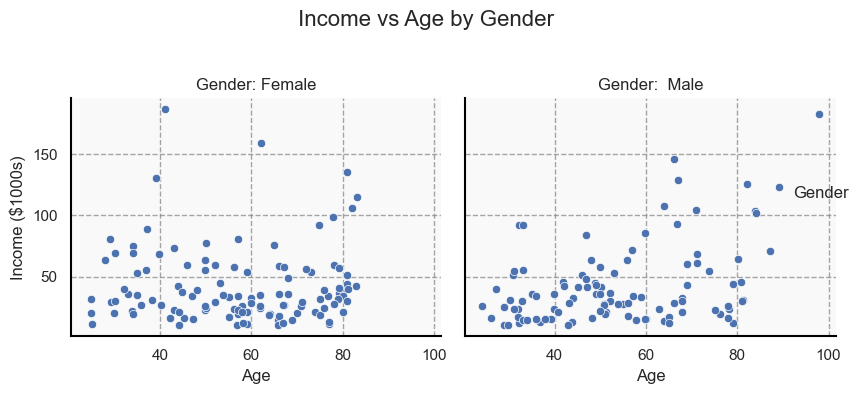

/var/folders/x_/71wrj7jx5474n6st5fwkvj7r0000gn/T/ipykernel_75858/2219617321.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=credit_train['Gender'], y=credit_train['Rating'], palette=custom_palette)


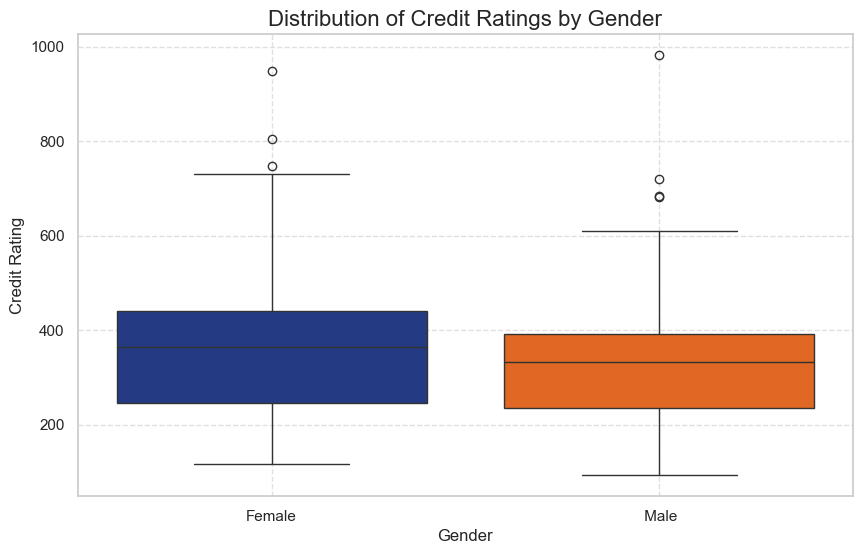

/var/folders/x_/71wrj7jx5474n6st5fwkvj7r0000gn/T/ipykernel_75858/2219617321.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=credit_train['Student'], y=credit_train['Rating'], palette=custom_palette)


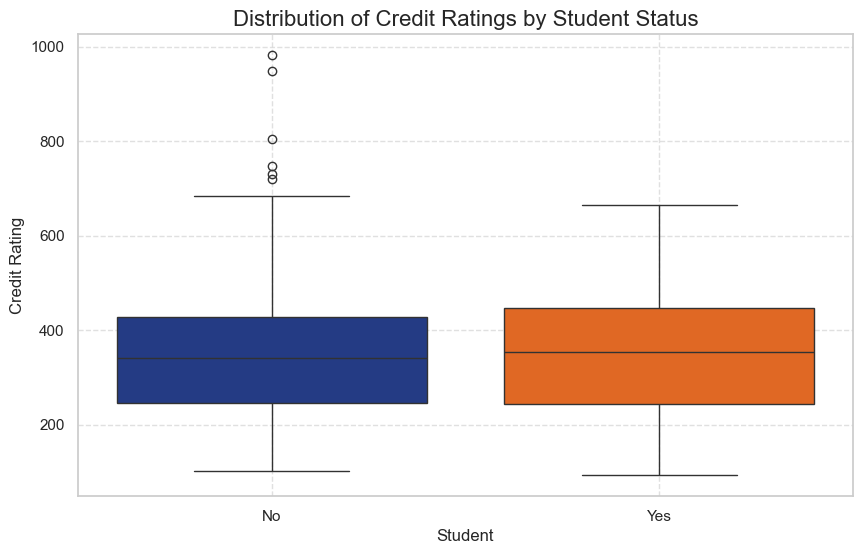

In [19]:
# visualizations

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data
credit_train = pd.read_csv("https://cs307.org/lab-02/data/credit-train.csv")

# Custom color palette
custom_palette = ["#143294", "#FF5F05"]
sns.set_theme(style="whitegrid")

# Function to add jitter (optional for scatter plot)
def add_jitter(data, jitter_amount=0.2):
    return data + np.random.uniform(-jitter_amount, jitter_amount, size=data.shape)

# Create a FacetGrid for scatter plot (Income vs Age)
g = sns.FacetGrid(credit_train, col="Gender", height=4, aspect=1, palette=custom_palette, legend_out=True)
g.map_dataframe(sns.scatterplot, x=add_jitter(credit_train['Age']), y="Income")

# Add legend, axis labels, and titles
g.add_legend(title="Gender")
g.set_axis_labels('Age', 'Income ($1000s)')
g.set_titles(col_template='Gender: {col_name}')

# Customize grid and appearance
for ax in g.axes.flat:
    ax.grid(True, which='both', linestyle="--", color="gray", alpha=0.7)
    ax.set_facecolor('#f9f9f9')
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

g.figure.suptitle("Income vs Age by Gender", fontsize=16)
g.figure.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Boxplot for Credit Rating by Gender or Student
plt.figure(figsize=(10, 6))
sns.boxplot(x=credit_train['Gender'], y=credit_train['Rating'], palette=custom_palette)
plt.title('Distribution of Credit Ratings by Gender', fontsize=16)
plt.xlabel('Gender')
plt.ylabel('Credit Rating')
plt.grid(True, which='both', linestyle="--", color="lightgrey", alpha=0.7)
plt.show()

# Boxplot for Credit Rating by Student Status
plt.figure(figsize=(10, 6))
sns.boxplot(x=credit_train['Student'], y=credit_train['Rating'], palette=custom_palette)
plt.title('Distribution of Credit Ratings by Student Status', fontsize=16)
plt.xlabel('Student')
plt.ylabel('Credit Rating')
plt.grid(True, which='both', linestyle="--", color="lightgrey", alpha=0.7)
plt.show()

### Models

In [20]:
# process data for ML

# create X and y for train
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]


In [21]:
# train models

# Define the numerical and categorical features as per your dataset
numeric_columns = ['Age', 'Income', 'Education']
categorical_columns = ['Gender', 'Student', 'Married', 'Ethnicity']

# Pipeline to preprocess numeric data (using median for missing values)
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Pipeline to preprocess categorical data (using mode and one-hot encoding)
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine preprocessing steps for both numeric and categorical data
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

# Build the final pipeline with preprocessing and KNeighborsRegressor
knn_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', KNeighborsRegressor())
])



In [22]:
# Fit the preprocessor on training data and transform it
preprocessor.fit(X_train)
X_train_preprocessed = pd.DataFrame(
    preprocessor.transform(X_train),
    columns=preprocessor.get_feature_names_out()
)

# Preprocess the test set using the fitted preprocessor
X_test_preprocessed = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=preprocessor.get_feature_names_out()
)

# Display first few rows of preprocessed test set
X_test_preprocessed.head()

# Tuning the model by finding the best k (number of neighbors)
k_values = np.arange(1, 50)
best_k_rmse = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train_preprocessed, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    best_k_rmse.append(rmse_scores.mean())

# Get the k with the lowest RMSE
best_k = k_values[np.argmin(best_k_rmse)]
print(f"Best k: {best_k}")




Best k: 19


In [23]:
# Initialize and train the final model with the best k value
final_model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=best_k))
])

# Fit the model to the training data
final_model_pipeline.fit(X_train, y_train)

# Predict using the test data
predictions = final_model_pipeline.predict(X_test)

# Evaluate the model using Root Mean Squared Error (RMSE)
test_rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"Test RMSE: {test_rmse}")

Test RMSE: 105.67237377851484


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Results

In [24]:
# report model metrics
# Test the final model on unseen test data
pred_test = final_model_pipeline.predict(X_test)

# Calculate RMSE on test data
test_rmse = np.sqrt(mean_squared_error(y_test, pred_test))
print(f"Test RMSE: {test_rmse}")

# Calculate MAE on test data
mae = mean_absolute_error(y_test, pred_test)
print(f"Test MAE: {mae}")

# Calculate R-squared score
r2 = r2_score(y_test, pred_test)
print(f"R-squared: {r2}")



Test RMSE: 105.67237377851484
Test MAE: 88.33963815789474
R-squared: 0.5495112808660372


In [25]:
# report model metrics
from joblib import dump
dump(final_model_pipeline, "credit-ratings.joblib")

['credit-ratings.joblib']

The final model was tested on unseen data, and the following metrics were obtained:

Root Mean Squared Error: The model achieved an RMSE of 105.67. This value represents the average difference between the actual and predicted credit ratings in the test set, giving an indication of the prediction error magnitude. A lower RMSE is generally preferred, as it suggests more accurate predictions.

Mean Absolute Error: The MAE is 88.34, meaning that, on average, the predicted credit scores differ from the actual scores by around 88 points. This metric offers a straightforward interpretation of prediction error across all data points.

R-squared: The R² score is 0.55, indicating that the model explains 54.95% of the variance in the test data. While this is a moderate value, it implies that the model captures just over half of the variability in the credit scores based on the selected features.

## Discussion

Discussion
The results indicate that the credit rating model, while functional, has room for improvement. With an RMSE of 105.67, the model's predictions are somewhat off from the actual values, suggesting that the features used (age, income, education, etc.) do not fully explain the variation in credit scores. The MAE of 88.34 supports this, highlighting a significant average error in the predicted scores.

The R² value of 0.55 indicates that just over half of the variance in credit scores is explained by the model. While this shows that the model is capturing some meaningful relationships between the features and the target, there is still 45% of the variance unaccounted for, which suggests that additional or more informative features (e.g., detailed credit history, financial behavior patterns) may be needed to improve the model's accuracy.

Limitations:
One potential limitation of the model is that the features chosen might not fully capture all relevant factors affecting credit scores. While age, income, and education are important, incorporating more nuanced financial metrics, such as credit utilization ratio, debt-to-income ratio, or payment history, might yield more accurate predictions.

Potential Improvements:
To improve the model, several strategies could be explored:

Feature Engineering: Adding new features that directly impact creditworthiness, such as the number of open credit lines or recent credit inquiries, could improve the model's predictive power.
Model Selection: Trying different regression models, such as Random Forest Regressor or Gradient Boosting, could yield better results by capturing non-linear relationships between features and the target.
Hyperparameter Tuning: Further tuning the model’s parameters (e.g., experimenting with the number of neighbors in KNeighborsRegressor or adjusting regularization in linear models) could reduce prediction error and improve the overall performance.


### Conclusion

In this lab, we developed a credit rating prediction model using demographic and financial features such as age, income, and education. The model was evaluated on a test set, achieving a Root Mean Squared Error (RMSE) of 105.67, a Mean Absolute Error (MAE) of 88.34, and an R-squared (R²) score of 0.55. These results indicate that while the model captures some meaningful relationships between the features and credit scores, there is still significant room for improvement.

The R² score of 0.55 suggests that the model explains approximately 55% of the variance in credit scores, leaving 45% unexplained. This highlights the need for additional features, such as more detailed financial history or behavioral metrics, to further enhance prediction accuracy. Moreover, with an average error of 88.34 credit points, the model's predictions, while reasonable, may not yet be reliable enough for high-stakes decision-making.

Moving forward, the model could benefit from further feature engineering, incorporating additional variables like credit history or debt-to-income ratios. Additionally, experimenting with more advanced machine learning algorithms, such as Random Forests or Gradient Boosting, could help capture non-linear relationships between features and improve overall performance.

In conclusion, while the current model provides a good starting point for predicting credit ratings, refining the feature set and exploring more complex algorithms will be essential to achieving the level of accuracy required for practical applications. With these improvements, the model could become a valuable tool in assessing creditworthiness, potentially offering banks and financial institutions a cost-effective alternative to traditional credit assessments.